#Step 1: Install Spark and Initialize Session

In [1]:
pip install pyspark

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("EDA Amazon Dataset") \
    .master("local[*]") \
    .config("spark.executor.memory", "20g") \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "20g") \
    .config("spark.default.parallelism", "100") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.serializer", "org.apache.spark.serializer.JavaSerializer") \
    .getOrCreate()

#Step 2: Load Data to be Analyzed

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType

schema = StructType([
    StructField("marketplace", StringType(), True),
    StructField("customer_id", StringType(), True),  # Change to IntegerType if applicable
    StructField("review_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("product_parent", StringType(), True),
    StructField("product_title", StringType(), True),
    StructField("product_category", StringType(), True),
    StructField("star_rating", IntegerType(), True),
    StructField("helpful_votes", IntegerType(), True),
    StructField("total_votes", IntegerType(), True),
    StructField("vine", StringType(), True),
    StructField("verified_purchase", StringType(), True),
    StructField("review_headline", StringType(), True),
    StructField("review_body", StringType(), True),
    StructField("review_date", DateType(), True)
])

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_paths = [
    '/content/drive/MyDrive/archive/amazon_reviews_us_Apparel_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Automotive_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Baby_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Beauty_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Books_v1_02.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Camera_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Electronics_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Furniture_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Sports_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Grocery_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv',
    '/content/drive/MyDrive/archive/amazon_reviews_us_Music_v1_00.tsv'
]

df = spark.read.csv(data_paths, schema=schema, header=True, sep='\t', mode='DROPMALFORMED')
df = df.repartition(2000)

#Step 3: Data Preprocessing before EDA

In [7]:
from pyspark.sql.functions import col, lower, regexp_replace, concat_ws, udf, substring, row_number

# Remove duplicates
df = df.dropDuplicates()

# Handle missing values for both review_body and review_headline simultaneously
df = df.na.fill({
    "review_body": "No review text",
    "review_headline": "No review headline"
})

df.cache()

DataFrame[marketplace: string, customer_id: string, review_id: string, product_id: string, product_parent: string, product_title: string, product_category: string, star_rating: int, helpful_votes: int, total_votes: int, vine: string, verified_purchase: string, review_headline: string, review_body: string, review_date: date]

#STEP 4: EDA


Number of records in each category of products

In [8]:
df_count = df.groupBy('product_category').count()
df_count.show(df_count.count())

+--------------------+-------+
|    product_category|  count|
+--------------------+-------+
|              Sports|4849329|
|                Baby|1752875|
|             Apparel|5906046|
|             Grocery|2402278|
|         Electronics|3093750|
|          Automotive|3514557|
|               Books|3105386|
|               Music|4750996|
|           Furniture| 792074|
|Personal_Care_App...|  85978|
|              Camera|1801916|
|              Beauty|5115103|
+--------------------+-------+



In [9]:
df.cache()
product_category = ['Sports', 'Baby', 'Apparel', 'Grocery', 'Electronics', 'Automotive', 'Books', 'Music', 'Furniture', 'Personal_Care_Appliances', 'Camera', 'Beauty']
data_filter = df.filter(df.product_category.isin(product_category))
df_filter_count = data_filter.groupBy('product_category').count()
df_filter_count.show(df_filter_count.count())

+--------------------+-------+
|    product_category|  count|
+--------------------+-------+
|              Sports|4849329|
|                Baby|1752875|
|             Apparel|5906046|
|             Grocery|2402278|
|         Electronics|3093750|
|          Automotive|3514557|
|               Books|3105386|
|               Music|4750996|
|           Furniture| 792074|
|Personal_Care_App...|  85978|
|              Camera|1801916|
|              Beauty|5115103|
+--------------------+-------+



In [15]:
sample_data = df.sample(fraction=0.05).toPandas()

This section of the notebook presents a visualization of the distribution of star ratings from the dataset. The visualization is created using a count plot, which effectively demonstrates the frequency of each star rating in the dataset.

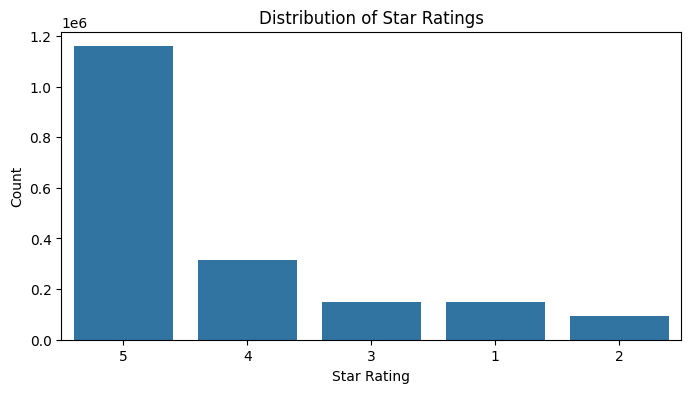

In [16]:
plt.figure(figsize=(8, 4))
sns.countplot(x='star_rating', data=sample_data, order=sample_data['star_rating'].value_counts().index)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

This code snippet calculates the length of each review and stores the results in a new column called `review_length`. It then visualizes the distribution of these lengths using a histogram with 30 bins, enhanced by a Kernel Density Estimate (KDE) to show the density trend, helping to understand how text length varies across reviews.

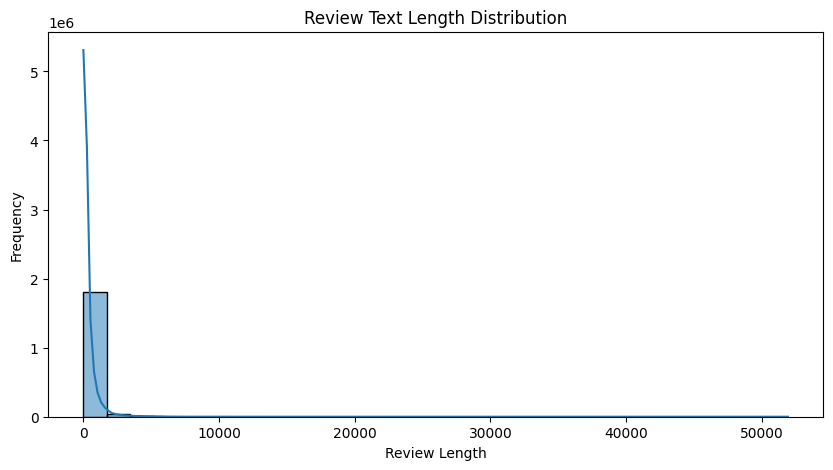

In [17]:
# Adding a new column for review length
sample_data['review_length'] = sample_data['review_body'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(sample_data['review_length'], bins=30, kde=True)
plt.title('Review Text Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

This code generates a boxplot to analyze the relationship between star ratings and the number of helpful votes each review receives, visualizing data distributions and identifying trends or outliers within specific rating categories. The y-axis is limited to 50 to focus on the majority of the data and improve clarity, filtering out extreme outliers.

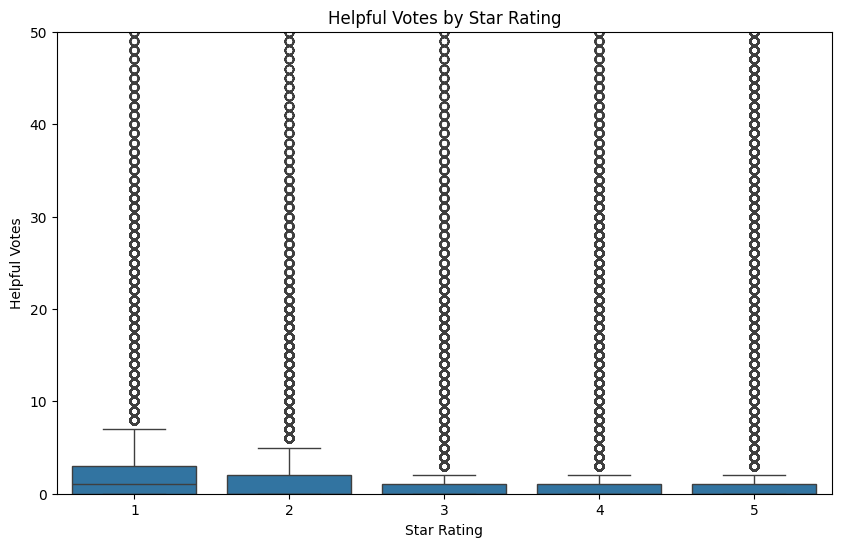

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='star_rating', y='helpful_votes', data=sample_data)
plt.title('Helpful Votes by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Helpful Votes')
plt.ylim(0, 50)  # Limit y-axis for better visualization, as there might be outliers
plt.show()

This snippet extracts numerical columns from the dataset for correlation analysis, calculating the correlation coefficients between variables such as star rating, helpful votes, total votes, and review length. A heatmap is then plotted to visually represent these correlations, using annotations to display the exact values and a color scale to indicate the strength and direction of each relationship.

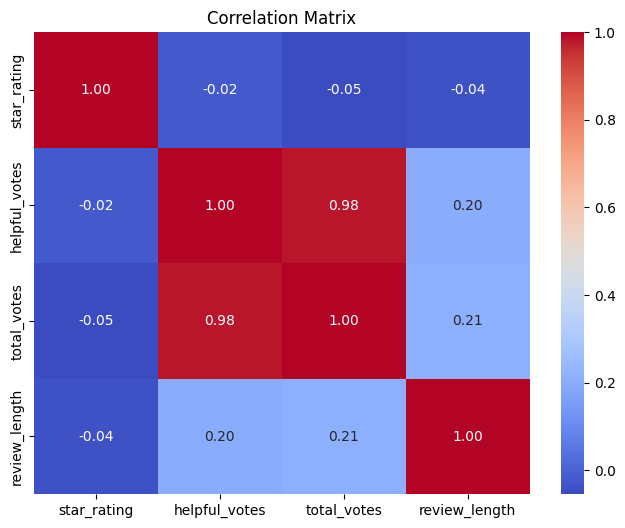

In [19]:
# Selecting numeric columns
numeric_data = sample_data[['star_rating', 'helpful_votes', 'total_votes', 'review_length']]

# Calculating correlations
correlation = numeric_data.corr()

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

This code registers the DataFrame df as a temporary SQL view named reviews, allowing SQL queries to be executed directly on the data. It then performs an SQL query to find the top 10 products based on the number of reviews received, calculating the average star rating for each, and displays the results in a pandas DataFrame for easy viewing and analysis.

In [20]:
df.createOrReplaceTempView("reviews")

# Querying with SQL
result = spark.sql("""
SELECT product_id, COUNT(*) as total_reviews, AVG(star_rating) as average_rating
FROM reviews
GROUP BY product_id
ORDER BY total_reviews DESC
LIMIT 10
""")

top_products = result.toPandas()

# Display results
print(top_products)

   product_id  total_reviews  average_rating
0  B001MA0QY2          15565        4.371282
1  B003L1ZYYM          15348        4.710125
2  B0002L5R78          11168        4.462751
3  B00DS842HS          10067        4.754445
4  B003EM8008           9780        4.364008
5  B0012S4APK           9365        4.414629
6  B0001FTVEK           8799        4.034208
7  B000WYVBR0           7847        4.579712
8  B0019EHU8G           7586        4.748616
9  B001HBHNHE           7405        4.896421


This code snippet aggregates the DataFrame `df` by `customer_id` to count the number of reviews each customer has submitted, renaming the count column to `num_reviews` for clarity. It then sorts these counts in descending order to identify the top reviewers and retrieves data for the top 10, displaying this information for review and analysis.

In [21]:
from pyspark.sql.functions import col

# Assuming df has been loaded and contains a column named 'customer_id'
review_counts = df.groupBy("customer_id").count().withColumnRenamed("count", "num_reviews")

# Order by the number of reviews in descending order to get the top reviewers
top_reviewers = review_counts.orderBy(col("num_reviews").desc())

# Fetch the top 10 reviewers data
top_10_reviewers = top_reviewers.take(10)

top_reviewers.show()

+-----------+-----------+
|customer_id|num_reviews|
+-----------+-----------+
|   50122160|      22331|
|   50732546|       9964|
|   50736950|       7943|
|   38214553|       5412|
|   51184997|       5371|
|   18116317|       4300|
|   23267387|       4051|
|   50345651|       3842|
|   52496677|       3000|
|   14539589|       2913|
|   15725862|       2852|
|   50913245|       2851|
|   50881246|       2802|
|   20018062|       2717|
|   22073263|       2682|
|   52615377|       2678|
|   19380211|       2592|
|   51381678|       2458|
|   37455882|       2371|
|   50441674|       2366|
+-----------+-----------+
only showing top 20 rows



In [22]:
# Convert list of Rows to a pandas DataFrame
top_10_df = pd.DataFrame(top_10_reviewers, columns=["customer_id", "num_reviews"])

<ipython-input-23-51c0505ad175>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x="customer_id", y="num_reviews", data=top_10_df, palette="viridis")


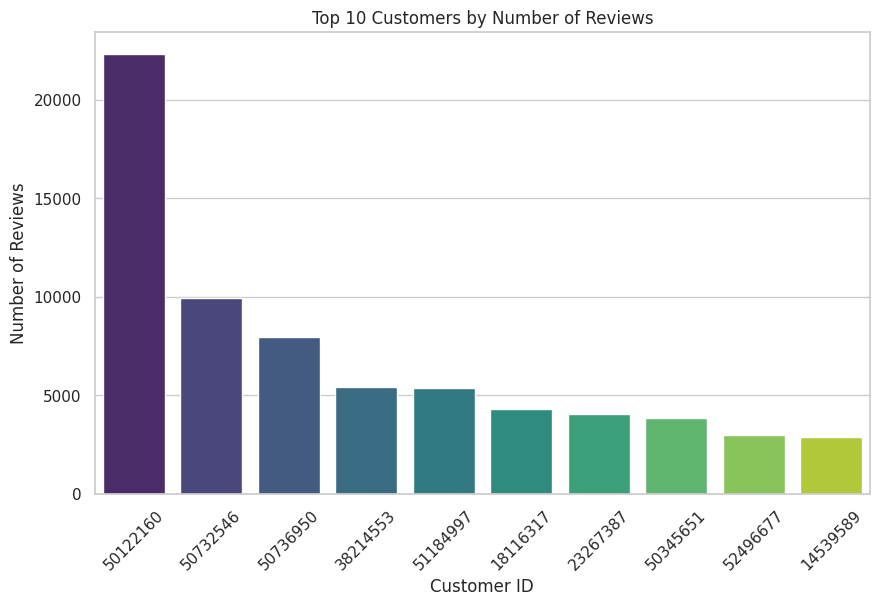

In [23]:
# Set the visual style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x="customer_id", y="num_reviews", data=top_10_df, palette="viridis")

# Set plot title and labels
plt.title('Top 10 Customers by Number of Reviews')
plt.xlabel('Customer ID')
plt.ylabel('Number of Reviews')

# Rotate the x labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [24]:
# Stop the Spark session
spark.stop()